In [2]:
# 목표 : 채무불이행 확률의 예측 정확도를 비교

# os 모델 가져오기 

import os 
import warnings
warnings.filterwarnings('ignore')

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 모델링 및 시각화

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import scipy.stats as stats


In [3]:
# 데이터 불러오기 

df=pd.read_csv("client_data.csv")

In [4]:
# 데이터가 제대로 적립되었는지 확인 

df.head(10)

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   
5   6      50000    1          1         2   37      0      0      0      0   
6   7     500000    1          1         2   29      0      0      0      0   
7   8     100000    2          2         2   23      0     -1     -1      0   
8   9     140000    2          3         1   28      0      0      2      0   
9  10      20000    1          3         2   35     -2     -2     -2     -2   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   
5  ...      19394      19619      20024      2500      1815       657   
6  ...     542653     483003     473944     55000     40000     38000   
7  ...        221       -159        567       380       601         0   
8  ...      12211      11793       3719      3329         0       432   
9  ...          0      13007      13912         0         0         0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0         0                           1  
1      1000         0      2000                           1  
2      1000      1000      5000                           0  
3      1100      1069      1000                           0  
4      9000       689       679                           0  
5      1000      1000       800                           0  
6     20239     13750     13770                           0  
7       581      1687      1542                           0  
8      1000      1000      1000                           0  
9     13007      1122         0                           0  

[10 rows x 25 columns]

In [5]:
# 불러온 데이터 재확인

df.shape


(30000, 25)

In [6]:
# 정보

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

In [7]:
# LIMIT_BAL  , BILL_AMT1  ~  PAY_AMT6  는 구체적인 수치이므로 정수 형태 함수가 아니다. 
# 따라서 이들은 float(실수)로 데이터 타입의 변경이 필요하다. 

df = df.astype({'LIMIT_BAL': 'float', 'BILL_AMT1': 'float', 'BILL_AMT2': 'float', 'BILL_AMT3': 'float','BILL_AMT4': 'float', 'BILL_AMT5': 'float', 'BILL_AMT6': 'float', 'PAY_AMT1': 'float', 'PAY_AMT2': 'float', 'PAY_AMT3': 'float', 'PAY_AMT4': 'float', 'PAY_AMT5': 'float', 'PAY_AMT6': 'float'})

In [8]:
# 데이터 타입 변경 후 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6   

## 데이터 해석

. 응답변수 : yes = 1 , no = 0을 할당하는 이진변수.
. 설명변수 (x) : 이 설명변수 간의 관계성을 파악해야 한다. 

X0: ID = 칼럼 명 이다.  
X1: 주어진 신용 금액(NT 달러): 개인 소비자 신용과 그/그녀의 가족(보충) 신용을 모두 포함
X2: 성별(1 = 남성, 2 = 여성).
X3: 학력(1 = 대학원, 2 = 대학, 3 = 고등학교, 4 = 기타).
X4: 결혼 상태(1 = 기혼, 2 = 독신, 3 = 기타). ㅌ
X5: 나이(년).

X6 - X11: 과거 지불 내역.  (2005년 4월부터 9월까지)
X6 = 2005년 9월 상환 상태
X7 = 2005년 8월 상환 상태 
......
X11 = 2005년 4월 상환 상태. 
이때 상환 상태(X6 ~ X11)에 대한 측정 척도는 다음과 같다. 
-1 = 적법하게 상환. 1 = 한 달 동안 상환 지연,  2 = 2개월 동안 지불 지연 ......  8 = 8개월 동안 상환 지연,  9 = 9개월 이상 지불 지연.

X12-X17: 청구서 금액(NT 달러).  (2005년 4월부터 9월까지)
X12 = 2005년 9월 청구서 금액 
X13 = 2005년 8월 청구서 금액 
......
X17 = 2005년 4월 청구서 금액.

X18-X23: 이전 지불 금액(NT 달러)  (2005년 4월부터 9월까지)
X18 = 2005년 9월에 지불한 금액
X19 = 2005년 8월에 지불한 금액 
......
X23 = 2005년 4월에 지불한 금액

x24 = 다음달 채무불이행 여부  ( yes = 1 , no = 0 의 값이 할당되어 있음)



따라서 x1 ~ X5의 상관괸계를 이하 x6 ~ x24를 이용하여 밝히는 것이 필요하다.   

## 데이터 분석

In [9]:
# 응답변수에 기반한 '다음달 채무불이행 여부'
# 0 은 NO , 1 은 YES

df=df.rename(columns={'default payment next month':'default'})
df.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

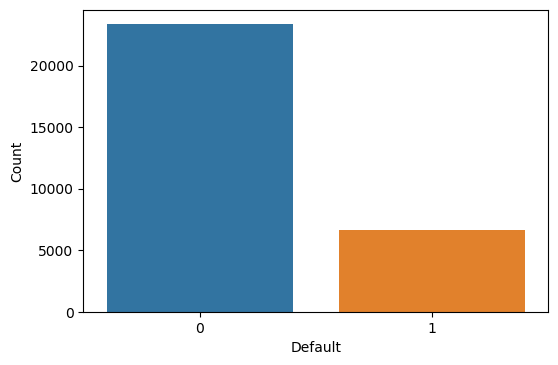

In [10]:
# 채무 불이행 여부를 'plot에 기반하여 시각화'

plt.figure(dpi=100)
sns.countplot(x="default", data=df)
plt.xlabel("Default")
plt.ylabel("Count")
plt.show()

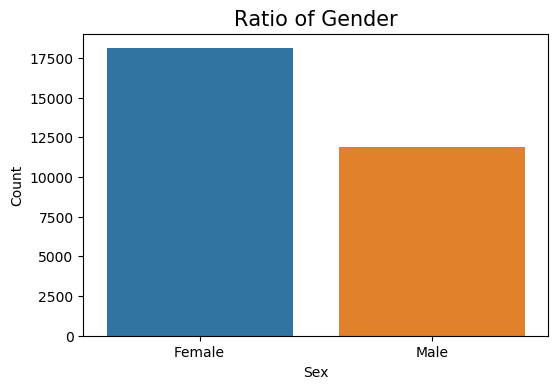

In [14]:
# 성별 변수를 활용하여 , 성별에 따른 데이터 시각화

df2=df.copy()

# 성별에 따른 데이터 값 할당
def sex1(x):
    if (x==1):
        return "Male"
    else:
        return "Female"
df2['SEX']=df['SEX'].apply(sex1)


plt.figure(dpi=100)
df2.SEX.value_counts()
sns.countplot(x="SEX", data=df2)
plt.title("Ratio of Gender", size=15)
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

In [15]:
# 성별에 따라서 구분된 데이터들을 , x3 학력을 이용하여 분석

df2.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

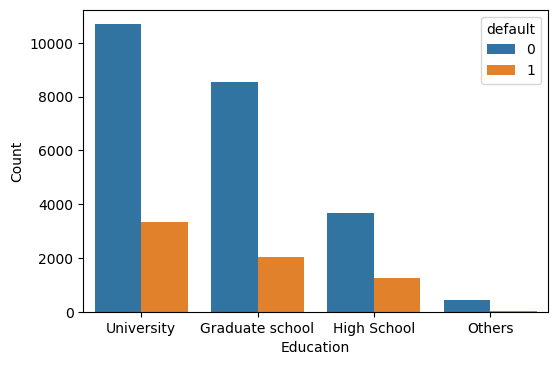

In [16]:
# 성별에 따라서 구분된 데이터들을 , x3 학력을 이용하여 시각화 

def edu(x):
    if (x==0) or (x==5) or (x==6):
        x=4
    return x
df['EDUCATION']=df['EDUCATION'].apply(edu)
df2['EDUCATION']=df2['EDUCATION'].apply(edu)
def edu1(x):
    if (x==1):
        return "Graduate school"
    elif (x==2):
        return "University"
    elif (x==3):
        return "High School"
    else:
        return "Others"
df2['EDUCATION']=df2['EDUCATION'].apply(edu1)
plt.figure(dpi=100)
df2.EDUCATION.value_counts()
sns.countplot(x="EDUCATION", hue="default", data=df2)
plt.xlabel("Education")
plt.ylabel("Count")
plt.show()

In [ ]:
다른 사람들의 코딩을 참고했을 때, 우선적으로 진행하는 것은 '다음달 채무불이행 여부 '의 이진변수를 나누어서 보는 것이 우선적으로 이루어짐.

순서에 차이가 있기는 하지만, '다음달 채무불이행 여부 ' 와 각 변수(x2 ~ x23) 들을 plot을 이용해서 분석을 진행함 

이후 최종적으로 모든 변수 끼리의 관계성을 보는 히트맵을 사용함으로써 최종적으로 변수간 상관관계성을 시각화함. 


https://www.kaggle.com/code/fegadeharish/eda-and-logistic-regression
    
https://www.kaggle.com/code/muskanbhasin/credit-card-default-prediction    